In [1]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Batch, Data, DataLoader, InMemoryDataset
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm, trange
from IPython.display import clear_output
from typing import Literal

torch.cuda.is_available()

True

In [2]:
from ML_functions import DEM_Dataset, Trainer, GetModel

In [3]:
dataset_name="2Sphere"
model_ident = "Model_1"
data_split=[0.85, 0.95]
pre_transform = T.Compose([T.Cartesian(False),
                           T.Distance(norm=False,cat=True)])
transform       = None
force_reload    = False
train           = False

dataset_test      =     DEM_Dataset(dataset_name,"test"    ,'delta', force_reload, pre_transform)

if train == True:
    dataset_train     = DEM_Dataset(dataset_name,"train"   ,'delta', force_reload, pre_transform)
    dataset_val       = DEM_Dataset(dataset_name,"validate",'delta', force_reload, pre_transform)

    model = GetModel(dataset_name,model_ident,edge_dim=4)
    trainer = Trainer(model, dataset_train,dataset_val,
                      batch_size=32,
                      lr=0.0000001,
                      epochs=2000,
                      model_name=f"{dataset_name}{model_ident}")
    #trainer.train_loop()

c:\Users\20182319\AppData\Local\anaconda3\envs\DEM-GNN2\Lib\site-packages\torch_geometric\data\dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
c:\Users\20182319\AppData\Local\anaconda3\envs\DEM-GNN2\Lib\site-packages\torch_geometric\io\fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([_reconstruct])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [4]:
def AverageDX(data):
    norm = torch.norm(data.y,dim=1)
    return torch.mean(norm)

dataset_test.y.abs().mean().item()

0.00045617528263905557

In [5]:
#print(dataset_train.pos.min(),dataset_train.pos.max())
#print(dataset_val.pos.min(),dataset_val.pos.max())
#print(dataset_test.pos.min(),dataset_test.pos.max())

#print(dataset_train.x.max(dim=0)[0])
#print(dataset_val.x.max(dim=0)[0])
#print(dataset_test.x.max(dim=0)[0])
#dataset_train.y.mean()

In [6]:
def FilterStart(dataset):
    idx = np.nonzero([data.time == 0 for data in dataset])
    return torch.utils.data.Subset(dataset_test,idx)[0]

#dataset_test_start = FilterStart(dataset_test)

In [7]:
from Encoding import ToPytorchData, GetLength

def GetLimits(data):
    max = [torch.max(data.x[:,i]) for i in [0, 1, 2]]
    min = [torch.min(data.x[:,i]) for i in [0, 1, 2]]
    max = torch.stack(max)
    min = torch.stack(min)
    limits = torch.stack([min,max],dim=1)
    return limits


In [8]:
class LearnedSimulator:
    def BCrollout(self):
        print("Calculating BC")
        BC_rollout = np.empty((GetLength(self.par_data),6,9))
        BC_t=np.copy(self.BC)
        for t in trange(GetLength(self.par_data)):
            BC_t[:,:3] = self.BC[:,:3]+(t+1)*self.BC[:,-3:] 
            BC_rollout[t] = BC_t
        return BC_rollout
    
    def GroundTruth_Rollout(self):
        print("Collecting Ground Truth Rollout")
        GroundTruth = np.empty(GetLength(self.par_data),dtype=object)
        for t in trange(GetLength(self.par_data)):
            data, MatlabTopology = ToPytorchData(self.par_data[t],self.BC_rollout[t],self.tol,self.topology[t],center=False)
            GroundTruth[t] = data
            GroundTruth[t].MatlabTopology = MatlabTopology
        return GroundTruth
    
    def MLRollout(self):
        print("Calculating Learned Rollout")
        with torch.inference_mode():
            ML_Rollout = np.empty((self.timesteps),dtype=object)
            par_inp = self.par_data[0]
            ML_Rollout[0], MatlabTopology = ToPytorchData(par_inp,self.BC_rollout[0],self.tol,center=False)
            ML_Rollout[0].MatlabTopology = MatlabTopology
            for t in tqdm(range(1,self.timesteps)):
                input_data, MatlabTopology = ToPytorchData(par_inp,self.BC_rollout[t],self.tol)
                    #transform = T.Compose([T.Cartesian(False), T.Distance(norm=False,cat=True)])
                input_data = self.transform(input_data)
                input_data.to(self.device)
                output = self.model(input_data)
                par_inp[:,:3] = par_inp[:,:3]+output[input_data.mask].cpu().numpy()
                output_data, MatlabTopology = ToPytorchData(par_inp,self.BC_rollout[t],self.tol,MatlabTopology,center=False)
                ML_Rollout[t] = output_data
                ML_Rollout[t].MatlabTopology = MatlabTopology
        return ML_Rollout
    
    def __init__(self,model,data_agr, top_agr,BC_agr,i: int,tol,transform,timesteps=100):
        self.device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')
        self.BC = BC_agr[i]
        self.par_data = data_agr[i]
        self.topology = top_agr[i]
        self.model = model.to(self.device)
        self.data_list = []
        self.timesteps = timesteps
        self.tol = tol
        self.transform = transform
        self.BC_rollout = self.BCrollout()
        self.GroundTruth = self.GroundTruth_Rollout()
        self.ML_rollout = self.MLRollout()

In [9]:
from Encoding import load
def SplitData(dataset_name,data_split):
    loaded_data = load(dataset_name)
    splits=np.array(data_split)*loaded_data[0].shape[0]
    test_data = [np.split(data,splits.astype(int))[2] for data in loaded_data]
    return test_data

In [10]:
from Encoding import load
from ML_functions import DataMask
def MaskTestData(dataset_name):
    """Masks out testdata from rawdata array

    Args:
        dataset_name (string): Name of the dataset

    Returns:
        tuple: [data, top, bc]
    """
    loaded_data = load(dataset_name)
    mask = DataMask(loaded_data[0],)[2]
    test_data = [data[mask] for data in loaded_data]
    return test_data

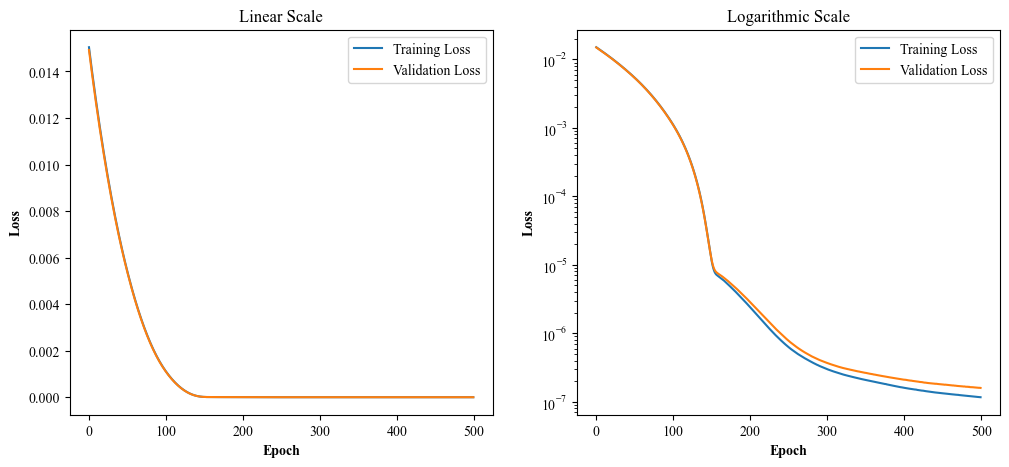

In [11]:
from Plotting import PlotTrainingLoss
fig, axs = PlotTrainingLoss(dataset_name,model_ident)

In [12]:
from Plotting import PlotXYZ
from ML_functions import NormalizePos, GetModel
dataset_name = "2Sphere"
model_ident = "Model_1"
model = GetModel(dataset_name,model_ident)

tol = 0
transform = T.Compose([NormalizePos(dataset_name),pre_transform])
AggregatedArgs = MaskTestData(dataset_name)

Loaded model


In [28]:
data = dataset_test[0]
data

Data(x=[8, 7], edge_index=[2, 8], pos=[8, 3], mask=[8], edge_mask=[8], y=[2, 3], edge_attr=[8, 4])

In [30]:
from Evaluation import GetGamma
gamma = GetGamma(data)
gamma

tensor([0.8917, 0.8917, 0.4447, 0.4447, 0.4459, 0.4447, 0.4447, 0.4459],
       dtype=torch.float64)

In [ ]:
for sample_idx in [6]:
    #AggregatedArgs = SplitData(dataset_name,data_split)
    Rollout = LearnedSimulator(model,*AggregatedArgs,i=sample_idx,tol=tol,transform=transform,timesteps=100)

    if dataset_name == "2Sphere": 
        PlotXYZ(Rollout,t_max=100)

In [ ]:
from Plotting import PlotGraphComparison
save = False
show = True
for t in range(1,100,20):  
    fig = PlotGraphComparison(t,Rollout,sample_idx,tol,plot_lines=True)
    if save == True: plt.savefig(f"{os.getcwd()}\\Figures\\Plots\\Graph_Sample{sample_idx}_Time{t}_Tol{str(tol)[2:]}.png",bbox_inches='tight')     
    if show == True: plt.show()

In [ ]:
from Plotting import PlotFres
from Evaluation import AggregateForces
Fcontact_GT,Fres_GT, Fnorm_GT, Fsum_GT = AggregateForces(Rollout.GroundTruth)
Fcontact_ML,Fres_ML, Fnorm_ML, Fsum_ML = AggregateForces(Rollout.ML_rollout)
fig = PlotFres(Fsum_GT,Fsum_ML)

In [ ]:
from Plotting import PlotStressComparison
fig, axs = PlotStressComparison(Rollout,Fcontact_GT,Fcontact_ML,False)

In [ ]:
from Plotting import PlotForceDistributionComparison
quantiles = [1,5,10,25,50]
fig, ax = PlotForceDistributionComparison(Fnorm_GT,Fnorm_ML,quantiles,False)

In [ ]:
import pyvista as pv
from Plotting import MakeGIF, PlotMeshNormals


#datalist = Rollout.ML_rollout
#gifname = f"ML_2_{sample_idx}_Tol{str(tol)[2:]}"
gifname = "Model1_nodeform"
datalist = Rollout.GroundTruth
datalist = Rollout.ML_rollout
MakeGIF(datalist,gifname,fps=8,color='lightblue',deformation=False)

#data = Rollout.ML_rollout[10]
#data = Rollout.GroundTruth[0]
#PlotMeshNormals(data)


In [ ]:
from Evaluation import GetContactForce
from Encoding import ConvertToDirected
data = Rollout.GroundTruth[0].clone()
force = GetContactForce(data)
GT = np.loadtxt('PairContact001.txt')

data =ConvertToDirected(data)
force2 = GetContactForce(data)

print(torch.norm(force,dim=1).size())
print(torch.norm(force2,dim=1))

torch.all(np.round(GT[:,2],2)==torch.round(torch.norm(force2,dim=1),decimals=2))

In [ ]:
data,top,bc = AggregatedArgs
top[0][0].shape, GT.shape

In [ ]:
from Plotting import GetInternalStressRollout
stress = GetInternalStressRollout(Rollout)
torch.set_printoptions(4)
print("Stress at time 0")
print(torch.round(stress[0],decimals=8)),
print("\nStress at time 99")
print(torch.round(stress[-1],decimals=1))

In [ ]:
from Plotting import PlotContactVectorAndForce, GetAllContactpoints,AxesLimits
data = Rollout.GroundTruth[0]
BC = Rollout.BC_rollout[3]
fig,axs = PlotContactVectorAndForce(data,BC)
for ax in axs: AxesLimits(ax,BC)

In [ ]:
data = Rollout.ML_rollout[0]
#data = Rollout.GroundTruth[0]